In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 24

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 200)               8600      
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                16080     
                                                                 
 dense_2 (Dense)             (None, 24)                1944      
                                                                 
Total params: 26624 (104.00 KB)
Trainable params: 26624 (104.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


355/369 [===========================>..] - ETA: 0s - loss: 1.5282 - accuracy: 0.5002
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
369/369 [==============================] - 3s 4ms/step - loss: 1.5087 - accuracy: 0.5047 - val_loss: 0.5958 - val_accuracy: 0.8182
Epoch 2/1000
 52/369 [===>..........................] - ETA: 0s - loss: 0.9430 - accuracy: 0.6647

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/369 [============================>.] - ETA: 0s - loss: 0.8383 - accuracy: 0.6954
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
369/369 [==============================] - 1s 4ms/step - loss: 0.8352 - accuracy: 0.6965 - val_loss: 0.3760 - val_accuracy: 0.9093
Epoch 3/1000
362/369 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.7601
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
369/369 [==============================] - 1s 4ms/step - loss: 0.6562 - accuracy: 0.7611 - val_loss: 0.2872 - val_accuracy: 0.9527
Epoch 4/1000
368/369 [============================>.] - ETA: 0s - loss: 0.5542 - accuracy: 0.8021
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
369/369 [==============================] - 1s 4ms/step - loss: 0.5544 - accuracy: 0.8020 - val_loss: 0.2114 - val_accuracy: 0.9701
Epoch 5/1000
363/369 [============================>.] - ETA: 0s - loss: 0.4703 - accuracy: 0.8331


In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

123/123 [==============================] - 0s 2ms/step - loss: 0.1502 - accuracy: 0.9538


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 122ms/step
[7.4488689e-08 2.4377380e-07 9.1009188e-01 5.2681368e-22 4.2893575e-07
 2.9658177e-05 4.0499423e-15 6.0298094e-10 2.8363092e-05 3.1000074e-08
 8.3650686e-13 7.4740534e-13 5.2860228e-18 8.9724556e-02 5.0204589e-12
 3.7112780e-08 1.8498893e-11 1.2477594e-04 1.4719003e-12 2.7001426e-20
 2.2592918e-20 3.4967904e-09 3.7515258e-11 8.1047255e-15]
2


# 混同行列

492/492 [==============================] - 1s 2ms/step


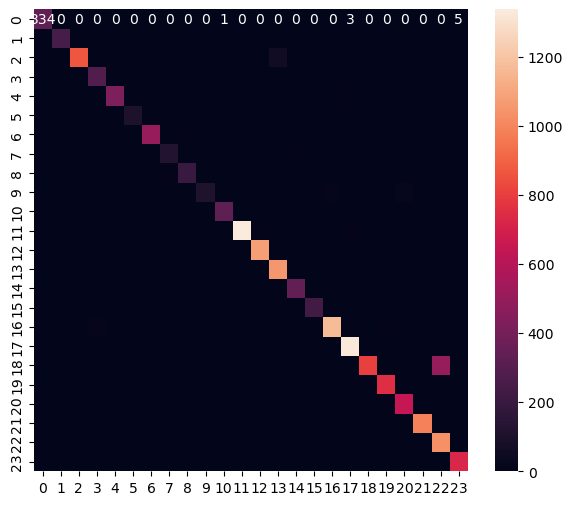

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       343
           1       0.97      0.99      0.98       251
           2       1.00      0.93      0.97       928
           3       0.96      1.00      0.98       279
           4       1.00      0.98      0.99       433
           5       0.97      0.92      0.94       109
           6       1.00      0.99      0.99       513
           7       0.92      0.94      0.93       131
           8       0.97      0.94      0.95       217
           9       1.00      0.73      0.85       146
          10       0.99      0.99      0.99       329
          11       1.00      0.99      0.99      1353
          12       0.99      1.00      1.00      1074
          13       0.94      1.00      0.97      1056
          14       0.97      0.99      0.98       340
          15       1.00      1.00      1.00       235
          16       0.98      0.98      0.98      1187
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\tanta\AppData\Local\Temp\tmp57sf406g\assets


INFO:tensorflow:Assets written to: C:\Users\tanta\AppData\Local\Temp\tmp57sf406g\assets


29800

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.26842231e-08 2.41284368e-07 8.90905619e-01 4.52144274e-22
 4.00141602e-07 3.21323278e-05 5.40042373e-15 7.38876349e-10
 3.08138078e-05 2.69903104e-08 6.79817043e-13 1.45817722e-12
 1.22615464e-17 1.08890854e-01 4.97411574e-12 4.30449205e-08
 3.01987359e-11 1.39745898e-04 1.66372222e-12 2.89469206e-20
 2.39728638e-20 3.17312687e-09 4.56955029e-11 9.96736534e-15]
2
